# Analysis Helpers

In [66]:
from collections import defaultdict, namedtuple, Counter
import re
from Bio.Alphabet import IUPAC, ThreeLetterProtein
from csv import DictReader
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np


# Amino acid 1-letter codes
AA1 = '[{}]'.format(''.join(IUPAC.IUPACProtein.letters))

# Amino acid 3-letter codes
three_letter_20 = list(set(ThreeLetterProtein.letters) - {
    'Asx',
    'Sec',
    'Glx',
    'Xaa'
})
AA3 = '({})'.format('|'.join(three_letter_20))

# Any amino acid representation
AAA = '({}|{})'.format(AA1, AA3)

# Gene symbols (from ftp://ftp.ebi.ac.uk/pub/databases/genenames/new/tsv/non_alt_loci_set.txt)
symbols = list()
with open('non_alt_loci_set.txt', 'r') as f:
    reader = DictReader(f, delimiter='\t')
    for row in reader:
        symbols.append(row['symbol'])

GENES = '\\b({})\\b'.format('|'.join(sorted(symbols, key=len, reverse=True)))

Token = namedtuple('Token', ['type', 'value', 'context', 'column'])

In [67]:
# regular expression strings
protein_substitution = '\\b{}\\d+{}\\b'.format(AAA, AAA)
protein_alternate = '\\b{}\\d+\\b'.format(AAA)
protein_duplication = '\\b{}\\d+_{}\\d+(DUP|dup)\\b'.format(AAA, AAA)
protein_frameshift = '\\b{}\\d+(FS|fs)(\\*\\d+)?\\b'.format(AAA)
protein_termination = '\\b{}\\d+X\\b'.format(AAA)
gene = GENES
exon = r'\b(EXON|Exon|exon) \d+\b'
expression = r'\b(OVER|UNDER)?EXPRESSION\b'
protein_delins = '\\b{}\\d+(_{}\\d+)?((DEL|del)|(INS|ins)|>)+{}*\\b'.format(AAA, AAA, AAA)
loss_of_function_term = r'\bLOSS[ -]OF[ -]FUNCTION\b'
gain_of_function_term = r'\bGAIN[ -]OF[ -]FUNCTION\b'
wild_type = r'\b(WILD TYPE)|WT\b'
amplification_term = r'\b(AMP(LIFICATION)?|(COPY NUMBER )?GAIN)\b'
deletion_term = r'\b(DEL(ETION)?|(COPY NUMBER )?LOSS)\b'
msi_h = r'\bMicrosatellite Instability-High\b'
dom = r'\b(\w+ )?(D|d)(omain|OMAIN)\b'
itd = r'\b(Internal tandem duplication)|(ITD)\b'
annotated = r'\(.*\)'
skip = r'[ \t\-/]+'
other_word = r'\w+'
other_character = '.'
open_group = r'\('
close_group = r'\)'

keywords = {
    'FUSION': 'FUS_KW',
    'FUSIONS': 'FUS_KW',
    'MUTATION': 'MUT_KW',
    'MUTATIONS': 'MUT_KW',
    'ABL': 'GENE',
    'SPLICING': 'SPLICE',
    'ALTERATION': 'MUT_KW',
    'NULL': 'LOF',
    'DELETERIOUS': 'LOF',
    'INACTIVATING': 'LOF',
    'ACTIVATING': 'GOF',
    'ONCOGENIC': 'ONC',
    'FRAMESHIFT': 'P_FS',
    'TRUNCATING': 'P_FS',
    'SPLICE': 'SPLICE',
    'INSERTION': 'P_DELINS',
    'DELETION': 'P_DELINS',
    'AMPLIFICATION': 'AMP',
    'WILDTYPE': 'WT',
    'DUPLICATION': 'DUP'
}

def tokenize(variant):
    token_specification = [
        ('GENE', gene),
        ('EXON', exon),
        ('P_FS', protein_frameshift),
        ('P_SUB', protein_substitution),
        ('P_TER', protein_termination),
        ('P_ALT', protein_alternate),
        ('P_DUP', protein_duplication),
        ('P_DELINS', protein_delins),
        ('LOF', loss_of_function_term),
        ('GOF', gain_of_function_term),
        ('AMP', amplification_term),
        ('DEL', deletion_term),
        ('EXP', expression),
        ('WT', wild_type),
        ('MSIH', msi_h),
        ('ITD', itd),
        ('DOM', dom),
        ('ANNOT', annotated),
        ('SKIP', skip),
        ('OPEN_GROUP', open_group),
        ('CLOSE_GROUP', close_group),
        ('OW', other_word),
        ('OC', other_character)
    ]
    tok_regex = '|'.join('(?P<%s>%s)' % pair for pair in token_specification)
    for mo in re.finditer(tok_regex, variant):
        kind = mo.lastgroup
        value = mo.group()
        column = mo.start()
        if kind == 'SKIP':
            continue
        elif kind == 'OW' and value.upper() in keywords:
            kind = keywords[value.upper()]
        yield Token(kind, value, variant, column)

def classify_variant(variant):
    tokens = list(tokenize(variant))
    types = [t.type for t in tokens]
    if len(types) > 1 and 'ANNOT' in types:
        types = [t for t in types if t != 'ANNOT']
    if len(types) > 1 and 'MUT_KW' in types:
        types = [t for t in types if t != 'MUT_KW']
    type_counts = Counter(types)
    if {'FUS_KW', 'GENE'} >= set(types):
        if type_counts['GENE'] < 2:
            return (variant, 'ONE_FUS')
        elif type_counts['GENE'] == 2:
            return (variant, 'TWO_FUS')
    elif 'OW' in types:
        return (variant, 'unknown')
    elif len(types) == 1:
        t = types[0]
        return (variant, t)
    elif types == ['EXON', 'MUT_KW']:
        return (variant, 'EXON_MUT')
    elif len(types) == 2 and 'EXON' in types:
        primary_type = [x for x in types if x != 'EXON'][0]
        return (variant, primary_type)
    elif len(types) > 1:
        return (variant, 'complex')
    else:
        return (variant, 'unknown')

def classify_variants(names):
    classifications = defaultdict(list)
    for name in names:
        v, c = classify_variant(name)
        classifications[c].append(v)
    for k in sorted(classifications, key=lambda x: len(classifications[x]), reverse=True):
        print('{}: {}'.format(k, len(classifications[k])))
    return(classifications)

# CIViC

In [68]:
import civicpy
from civicpy import civic

In [69]:
civicpy.version()

'0.0.3a1'

In [70]:
try:
    civic_variants
except NameError:
    civic_variants = civic.get_all_variants()

In [71]:
names = [v.name for v in civic_variants]

In [72]:
civic_classified = classify_variants(names)

P_SUB: 883
unknown: 220
P_FS: 202
EXP: 196
complex: 148
P_DELINS: 104
MUT_KW: 75
TWO_FUS: 73
AMP: 47
LOF: 40
DEL: 38
SPLICE: 35
P_ALT: 24
ONE_FUS: 20
EXON: 17
P_TER: 10
WT: 6
P_DUP: 4
DOM: 3
ITD: 1
GOF: 1


# OncoKB

In [73]:
# From https://oncokb.org/api/v1/utils/allActionableVariants.txt
try:
    oncokb_variants
except NameError:
    oncokb_variants = list()
    with open('allActionableVariants.txt', 'r') as f:
        reader = DictReader(f, delimiter='\t')
        for row in reader:
            oncokb_variants.append(row['Alteration'])

In [74]:
oncokb_classified = classify_variants(oncokb_variants)

P_SUB: 72
ONC: 44
P_ALT: 19
ONE_FUS: 18
AMP: 10
P_DELINS: 6
TWO_FUS: 5
EXON: 5
MSIH: 2
SPLICE: 2
P_FS: 2
complex: 1
WT: 1
ITD: 1


# Visualization

In [75]:
all_keys = set(civic_classified) | set(oncokb_classified)
civic_total = sum([len(x) for x in civic_classified.values()])
oncokb_total = sum([len(x) for x in oncokb_classified.values()])

In [76]:
proportions = dict()
for key in all_keys:
    civic_p = len(civic_classified.get(key, [])) / civic_total
    oncokb_p = len(oncokb_classified.get(key, [])) / oncokb_total
    proportions[key] = [civic_p, oncokb_p]

In [77]:
sorted_keys = sorted(proportions, key=lambda x: max(proportions[x]), reverse=True)
sorted_keys = [x for x in sorted_keys if x != 'unknown']
sorted_keys.append('unknown')

In [78]:
civic_p_list = [proportions[k][0] for k in sorted_keys]
oncokb_p_list = [proportions[k][1] for k in sorted_keys]

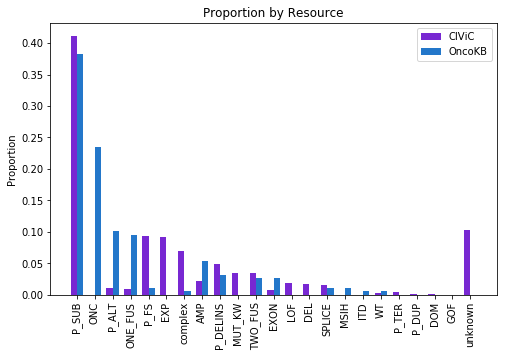

In [79]:
ind = np.arange(len(sorted_keys))
width = 0.35

fig, ax = plt.subplots()
fig.set_size_inches(8, 5)
rects1 = ax.bar(ind - width/2, civic_p_list, width, label='CIViC', color=(120/255,40/255,210/255))
rects2 = ax.bar(ind + width/2, oncokb_p_list, width, label='OncoKB', color=(35/255, 119/255, 202/255))

ax.set_ylabel('Proportion')
ax.set_title('Proportion by Resource')
ax.set_xticks(ind)
ax.set_xticklabels(sorted_keys, rotation='vertical')
ax.legend()

plt.show()
fig.savefig('prop_by_resource.png', dpi=300, bbox_inches = 'tight')

In [80]:
sum('(' in term for term in civic_classified['P_SUB'])

268

In [81]:
len(civic_classified['P_SUB'])

883

In [82]:
268 /883

0.3035107587768969

In [83]:
civic_sub_variants = [x for x in civic_variants if x.name in civic_classified['P_SUB']]

In [84]:
genes = Counter([x.gene for x in civic_sub_variants if '(' in x.name])

In [85]:
[x for x in civic.get_gene_by_id(3532).variants if '(' in x.name]

[<CIViC variant 2346>]

In [86]:
v = civic.get_variant_by_id(2346)

In [87]:
v.site_link

'https://civicdb.org/links/variant/2346'